# 3. Building network and training

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import datetime

2023-05-24 13:37:57.634790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 13:37:57.779099: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-24 13:37:57.779136: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-24 13:37:58.594191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [17]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
print(physical_devices)

Num GPUs: 0
[]


In [3]:
import boto3
from boto3 import session
import os

key_id = os.environ.get("AWS_ACCESS_KEY_ID")
secret_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
bucket_name = os.environ.get("AWS_S3_BUCKET")
s3_endpoint = os.environ.get("AWS_S3_ENDPOINT")

s3_client = boto3.client("s3", aws_access_key_id=key_id, aws_secret_access_key=secret_key, endpoint_url=s3_endpoint)

In [ ]:
X_train = np.load('/tmp/ml-pipeline/data/X_train.npy')
y_train = np.load('/tmp/ml-pipeline/data/y_train.npy')
X_val = np.load('/tmp/ml-pipeline/data/X_val.npy')
y_val = np.load('/tmp/ml-pipeline/data/y_val.npy')
X_test = np.load('/tmp/ml-pipeline/data/X_test.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ml-pipeline/data/X_train.npy'

> <div class="alert alert-block alert-info">
<b>ConvBlocks in this network will follow the LeNet design as shown above, with a few additions including Batch normalization and dropout to keep network speeds running optimally and reduce the chances of network overfitting. </b>
    <br></br>
    <b>You can find more on LeNet's here: https://en.wikipedia.org/wiki/LeNet</b></div>

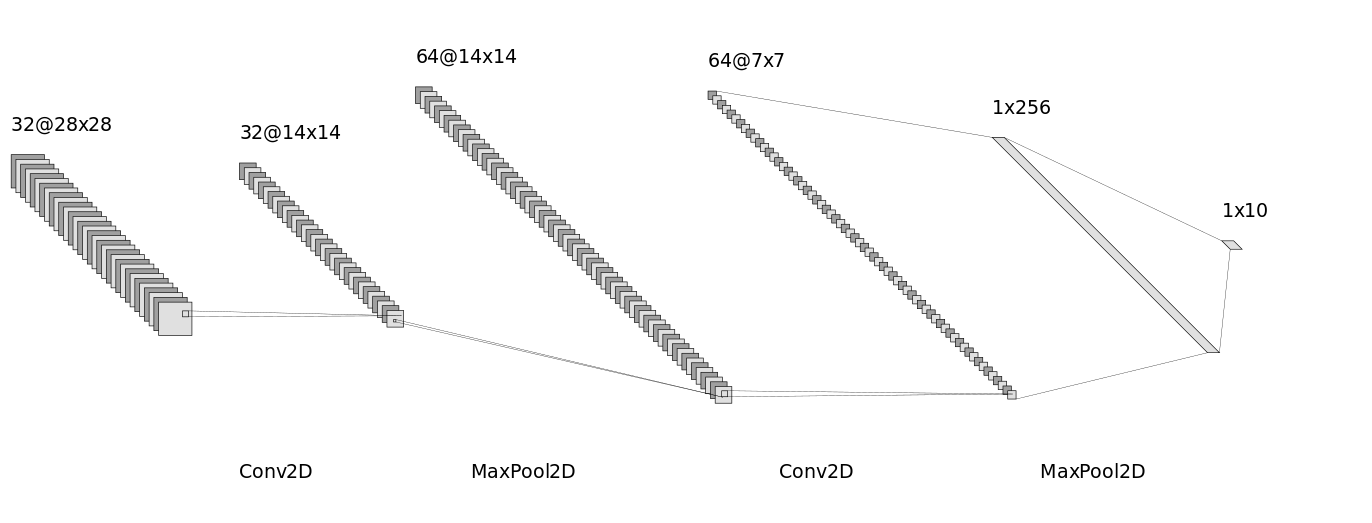

> <div class="alert alert-block alert-info">
<b>The above figure shows the best parameter combination I found after experimenting with a few variations. One thing to keep in mind when experiementing with CNN's is that increasing filters throughout the layers tends to be best.</b>
</div>

###  2.6 Custom f1, recall and precision metrics

> <div class="alert alert-block alert-info">
<b>We will now create some custom metrics, to help aid us in evaluating model performance. F1-score, Recall and precision are not pre-defined metrics avaliable in keras, which is why we have to manually create them ourselves.</b></div>

> <div class="alert alert-block alert-info">
<b>Using Keras backend, we have now defined the following metric functions; precision, recall and f1. (Epsilon is used to avoid infinite value error caused by division of zero).</b></div>

### 3.1 Building network

In [6]:
def build_model():
    inp = keras.Input(shape=(28,28,1), name="input_1")
    x = keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1),padding='SAME', 
                              activation='relu')(inp)
    x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=(5,5), padding='SAME', activation='relu')(x)
    x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inp, outputs=output)

    model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model, inp, output

> <div class="alert alert-block alert-info">
    <b>The model is built and compiled using categorical crossentropy and adam optimizer.</b>
</div>

In [7]:
model, inp, out = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        51264 

2023-05-24 13:38:01.200217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
from keras.utils.vis_utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### 3.2 Training network

> <div class="alert alert-block alert-info">
    <b>Ok, we've built the network. Now, let's train it.</b>
</div>

In [9]:
batch_size=32

In [10]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1, batch_size=batch_size,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=10, 
                                                             min_delta=0.005, restore_best_weights=True),
                              keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 3)])

1182/1182 [==============================] - 99s 83ms/step - loss: 0.4459 - accuracy: 0.8602 - val_loss: 0.1164 - val_accuracy: 0.9648 - lr: 1.0000e-04


In [10]:
os.makedirs('/tmp/ml-pipeline/model/', exist_ok=True)

In [11]:
model.save("/tmp/ml-pipeline/model/saved_model")

INFO:tensorflow:Assets written to: /tmp/saved_model/assets


INFO:tensorflow:Assets written to: /tmp/saved_model/assets


In [12]:
!python -m tf2onnx.convert --saved-model /tmp/ml-pipeline/model/saved_model --output /tmp/ml-pipeline/model/model.onnx --opset 13

2023-05-24 13:39:42.925385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 13:39:43.062758: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-24 13:39:43.062799: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-24 13:39:43.786138: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [13]:
import boto3
import os

key_id = os.environ.get("AWS_ACCESS_KEY_ID")
secret_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
bucket_name = os.environ.get("AWS_S3_BUCKET")
s3_endpoint = os.environ.get("AWS_S3_ENDPOINT")

s3_client = boto3.client("s3", aws_access_key_id=key_id, aws_secret_access_key=secret_key, endpoint_url=s3_endpoint)

In [14]:
s3_client.upload_file("/tmp/ml-pipeline/model/model.onnx", bucket_name, "onnx/model-v2.onnx")

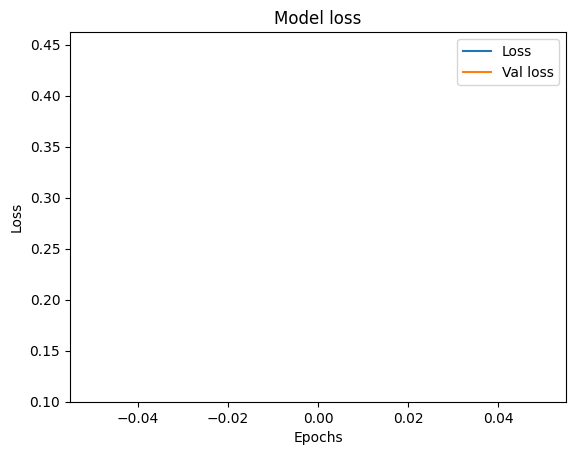

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss','Val loss'])

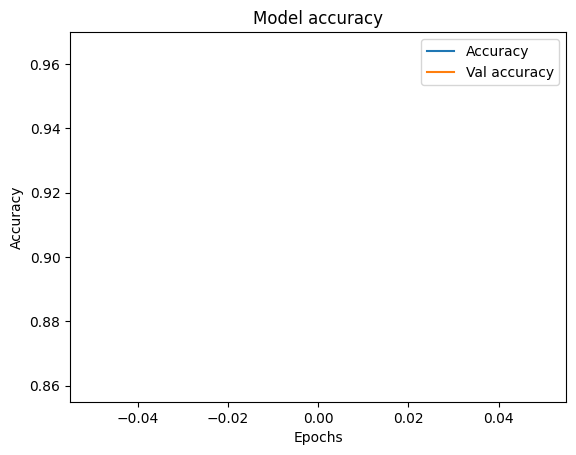

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy','Val accuracy'])